# Inspecting the training data

In [22]:
import json
import random
import logging
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ataarangi.rakau import WorldState
from ataarangi.data import encode_world_state

In [2]:
json_data = []
world_states = []
with open('../data/world_states.jsonl', 'r') as f:
    for line in f.readlines():
        j = json.loads(line)
        json_data.append(j)
        world_states.append(
            WorldState.from_dict(j['sticks'])
        )

In [3]:
json_data[0]

{'id': '800d23b5-574c-46d3-94cf-1066082e9d7d',
 'description': 'te rākau mā',
 'sticks': {'ngā_rākau': [{'color': 'blue',
    'height': 4,
    'location': 3,
    'selected': False},
   {'color': 'white', 'height': 8, 'location': 5, 'selected': True}]},
 'entropy': 3.0,
 'image_path': 'data/graphs/800d23b5-574c-46d3-94cf-1066082e9d7d.png'}

In [4]:
state = WorldState.from_dict(json_data[0]['sticks'])

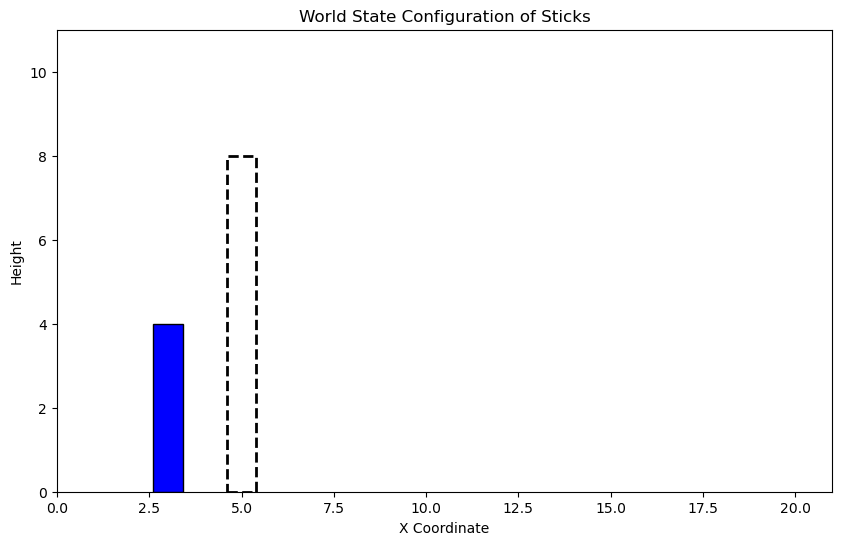

In [5]:
state.draw()

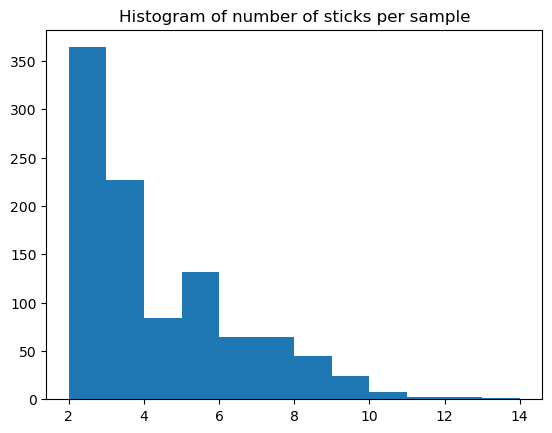

In [6]:
fig, ax = plt.subplots()
plt.hist([len(j['sticks']['ngā_rākau']) for j in json_data], bins=12)
ax.set_title("Histogram of number of sticks per sample")
plt.show()

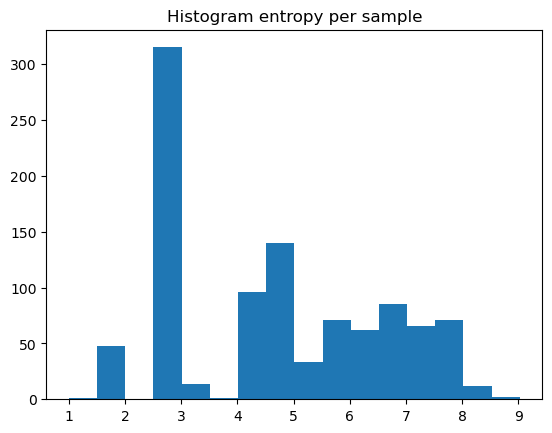

In [7]:
fig, ax = plt.subplots()
plt.hist([j['entropy'] for j in json_data], bins=16)
ax.set_title("Histogram entropy per sample")
plt.show()

Based on this plot, it's probably enough to filter out samples with more than 10 sticks as being 'too complicated'. That'll help us keep the feature matrices compact, which hopefully will help with learning.

## Generating world state features

In [8]:
from ataarangi.data import WorldStateTokenizer

In [9]:
# Example usage
sticks_data = [
    {'color': 'blue', 'height': 4, 'location': 3},
    {'color': 'white', 'height': 8, 'location': 5}
]

In [10]:
ws_tokenizer = WorldStateTokenizer('../data/worldstate_tokens.txt')
ws_tokenizer.tokenize([sticks_data])

[[1, 11, 5, 15, 18]]

## Looking at the text descriptions

<Axes: title={'center': 'Most common sequence descriptions'}>

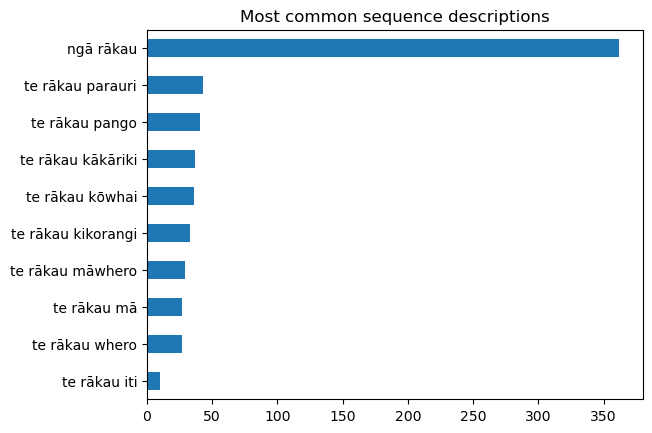

In [11]:
(pd.Series(
    [j['description'] for j in json_data]
    ).value_counts()
     .head(10)
     .sort_values()
     .plot(kind='barh', title='Most common sequence descriptions')
)

In [12]:
print(f"{len([j for j in json_data if j['description'] == 'ngā rākau']) / len(json_data)*100:.1f}% of descriptions are 'ngā rākau'")

35.6% of descriptions are 'ngā rākau'


In [13]:
descriptions = pd.Series([j['description'] for j in json_data])
word_counts = pd.Series(' '.join(descriptions).split(' ')).value_counts()
print(f"{len(word_counts)} words in the vocab")
word_counts

30 words in the vocab


rākau        1481
te           1031
ngā           510
me            401
mā            137
kākāriki      134
kōwhai        134
kikorangi     133
parauri       132
pango         127
whero         117
māwhero       116
iti            89
nui            83
hāunga         64
katoa          62
rawa           41
taha           37
kei            37
mauī           33
matau          26
ki             24
tawhiti        22
e              16
rua            15
waenganui       5
i               3
toru            1
tuarua          1
mai             1
Name: count, dtype: int64

## Assembling a dataset

In [14]:
rākau_data = pd.DataFrame(
    {
        'id': [j['id'] for j in json_data],
        'entropy': [j['entropy'] for j in json_data],
        'rākau': [j['sticks']['ngā_rākau'] for j in json_data],
        'description': descriptions
    }
)
rākau_data['num_rākau'] = rākau_data['rākau'].apply(len)
rākau_data

,id,entropy,rākau,description,num_rākau
0,800d23b5-574c-46d3-94cf-1066082e9d7d,3.0,"[{'color': 'blue', 'height': 4, 'location': 3,...",te rākau mā,2
1,659289fa-7473-4617-a8f0-61324cc0e3b1,2.0,"[{'color': 'blue', 'height': 1, 'location': 8,...",ngā rākau,2
2,7629eca4-df36-4921-973b-0ca7859c5018,3.0,"[{'color': 'blue', 'height': 1, 'location': 4,...",te rākau iti,2
3,89413927-94ca-4078-8198-85b957338400,3.0,"[{'color': 'green', 'height': 2, 'location': 1...",te rākau mā,2
4,eb110390-7be8-4d7a-93e0-211c33c033f1,3.0,"[{'color': 'black', 'height': 10, 'location': ...",ngā rākau,2
...,...,...,...,...,...
1012,3d543250-f7c8-47c4-9491-ab29d5c8c8fd,3.0,"[{'color': 'blue', 'height': 8, 'location': 18...",te rākau kikorangi,2
1013,b6fcfe8b-5604-47d5-8e1a-1a2830219683,3.0,"[{'color': 'white', 'height': 4, 'location': 1...",te rākau mā,2
1014,ecc53392-b801-4159-8fe3-fe9475e50672,3.0,"[{'color': 'black', 'height': 2, 'location': 1...",te rākau whero,2
1015,bd1d8542-5e5f-4d03-9bf3-8b3d889fe737,3.0,"[{'color': 'yellow', 'height': 3, 'location': ...",ngā rākau,2


te rākau pango kei te taha mauī


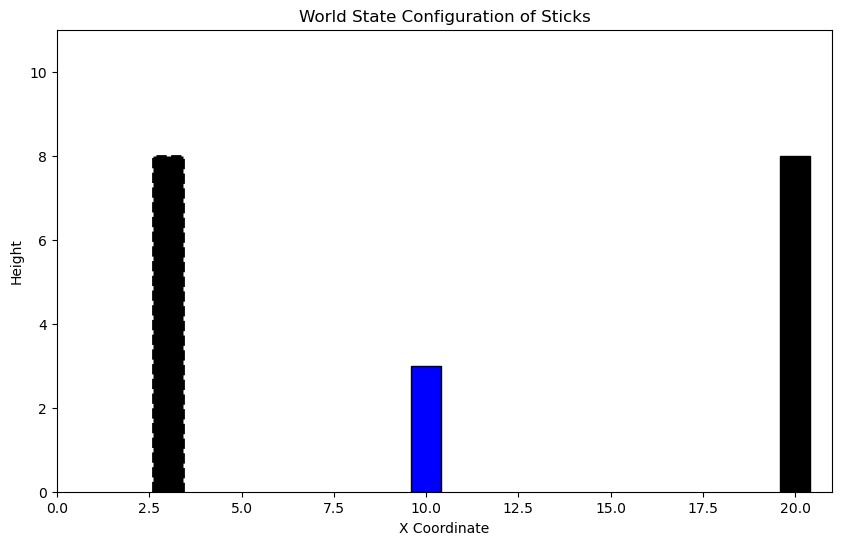

In [15]:
id = 'c26646db-3e36-4e8d-8652-264ec4d917cb'
print(rākau_data.loc[rākau_data.id == id, 'description'].values[0])
WorldState.from_dict({'ngā_rākau': rākau_data.loc[rākau_data.id == id, 'rākau'].values[0]}).draw()

## Preparing a tokenizer

In [16]:
token_counts = pd.Series(' '.join(rākau_data.description).split(' ')).value_counts()
token_counts

rākau        1481
te           1031
ngā           510
me            401
mā            137
kākāriki      134
kōwhai        134
kikorangi     133
parauri       132
pango         127
whero         117
māwhero       116
iti            89
nui            83
hāunga         64
katoa          62
rawa           41
taha           37
kei            37
mauī           33
matau          26
ki             24
tawhiti        22
e              16
rua            15
waenganui       5
i               3
toru            1
tuarua          1
mai             1
Name: count, dtype: int64

In [17]:
with open('../data/tokens.txt', 'w') as f:
    for token in list(token_counts.index):
        f.write(f"{token}\n")
    f.write("[END]")

In [18]:
! cat ../data/tokens.txt

rākau
te
ngā
me
mā
kākāriki
kōwhai
kikorangi
parauri
pango
whero
māwhero
iti
nui
hāunga
katoa
rawa
taha
kei
mauī
matau
ki
tawhiti
e
rua
waenganui
i
toru
tuarua
mai
[END]

## Saving rākau data to disk

In [19]:
rākau_data['rākau'] = rākau_data.rākau.apply(json.dumps)

In [37]:
def deterministic_split(data, train_ratio=0.7, dev_ratio=0.15, test_ratio=0.15, id_column='id'):
    """
    Splits the data into train, development, and test sets based on hash values of an identifier column.
    
    Args:
    - data (DataFrame): The pandas DataFrame to split.
    - train_ratio (float): The proportion of the data to allocate to the training set.
    - dev_ratio (float): The proportion of the data to allocate to the development set.
    - test_ratio (float): The proportion of the data to allocate to the test set.
    - id_column (str): The name of the column used as a unique identifier for hashing.
    
    Returns:
    - train_set (DataFrame): The training set.
    - dev_set (DataFrame): The development set.
    - test_set (DataFrame): The test set.
    """
    if not np.isclose(train_ratio + dev_ratio + test_ratio, 1.0):
        raise ValueError("The sum of train, dev, and test ratios must be 1.")

    # Calculate thresholds based on ratios
    threshold1 = train_ratio  # Adjust the scale according to the hash output size (32 hex digits)
    threshold2 = (train_ratio + dev_ratio)

    def assign_set(x):
        # Hash the identifier
        hash = hashlib.md5(str(x).encode()).hexdigest()
        hash_val = int(hash, 16) / 16**32
        
        # Assign set based on hash value
        if hash_val < threshold1:
            return 'train'
        elif hash_val < threshold2:
            return 'dev'
        else:
            return 'test'

    # Apply hashing and thresholds to assign sets
    data['train_set'] = data[id_column].apply(assign_set)

    # Split the data
    train_set = data[data['train_set'] == 'train']
    dev_set = data[data['train_set'] == 'dev']
    test_set = data[data['train_set'] == 'test']

    return train_set.drop(columns='train_set'), dev_set.drop(columns='train_set'), test_set.drop(columns='train_set')

# Split the data deterministically
train_set, dev_set, test_set = deterministic_split(rākau_data, train_ratio=0.8, dev_ratio=0.1, test_ratio=0.1, id_column='id')

print(f"Train Set: {len(train_set)}")
print(train_set.head())
print(f"\nDev Set: {len(dev_set)}")
print(dev_set.head())
print(f"\nTest Set: {len(test_set)}")
print(test_set.head())

Train Set: 778
                                     id  entropy  num_rākau  \
0  800d23b5-574c-46d3-94cf-1066082e9d7d      3.0          2   
1  659289fa-7473-4617-a8f0-61324cc0e3b1      2.0          2   
2  7629eca4-df36-4921-973b-0ca7859c5018      3.0          2   
3  89413927-94ca-4078-8198-85b957338400      3.0          2   
5  90be1900-85fb-43a9-a069-c52a09ff6625      3.0          2   

                                               rākau   description  
0  [{"color": "blue", "height": 4, "location": 3,...   te rākau mā  
1  [{"color": "blue", "height": 1, "location": 8,...     ngā rākau  
2  [{"color": "blue", "height": 1, "location": 4,...  te rākau iti  
3  [{"color": "green", "height": 2, "location": 1...   te rākau mā  
5  [{"color": "pink", "height": 6, "location": 2,...     ngā rākau  

Dev Set: 132
                                      id  entropy  num_rākau  \
12  76204705-84fe-4c6d-bd70-f101bbe1bb64      3.0          2   
15  01345805-7fa5-4457-9a2e-a59529ce87fa      3.0 

/tmp/ipykernel_48201/1894983970.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['train_set'] = data[id_column].apply(assign_set)


In [39]:
train_set

,id,entropy,num_rākau,rākau,description
0,800d23b5-574c-46d3-94cf-1066082e9d7d,3.0,2,"[{""color"": ""blue"", ""height"": 4, ""location"": 3,...",te rākau mā
1,659289fa-7473-4617-a8f0-61324cc0e3b1,2.0,2,"[{""color"": ""blue"", ""height"": 1, ""location"": 8,...",ngā rākau
2,7629eca4-df36-4921-973b-0ca7859c5018,3.0,2,"[{""color"": ""blue"", ""height"": 1, ""location"": 4,...",te rākau iti
3,89413927-94ca-4078-8198-85b957338400,3.0,2,"[{""color"": ""green"", ""height"": 2, ""location"": 1...",te rākau mā
5,90be1900-85fb-43a9-a069-c52a09ff6625,3.0,2,"[{""color"": ""pink"", ""height"": 6, ""location"": 2,...",ngā rākau
...,...,...,...,...,...
1012,3d543250-f7c8-47c4-9491-ab29d5c8c8fd,3.0,2,"[{""color"": ""blue"", ""height"": 8, ""location"": 18...",te rākau kikorangi
1013,b6fcfe8b-5604-47d5-8e1a-1a2830219683,3.0,2,"[{""color"": ""white"", ""height"": 4, ""location"": 1...",te rākau mā
1014,ecc53392-b801-4159-8fe3-fe9475e50672,3.0,2,"[{""color"": ""black"", ""height"": 2, ""location"": 1...",te rākau whero
1015,bd1d8542-5e5f-4d03-9bf3-8b3d889fe737,3.0,2,"[{""color"": ""yellow"", ""height"": 3, ""location"": ...",ngā rākau


In [38]:
train_set.to_csv('../data/train_set.csv', index=False)
test_set.to_csv('../data/test_set.csv', index=False)
dev_set.to_csv('../data/dev_set.csv', index=False)

In [30]:
rākau_data = rākau_data[['id', 'entropy', 'num_rākau', 'rākau', 'description']]
rākau_data.to_csv('../data/rākau_data.csv', index=False)